# Backwards Greedy OLS
OMP can be seen as a Forward Greedy OLS. We perform Ordinary Least Squares on a restricted set of features. We do this in a forward manner; we we start with an empty graph, and we greedily add edges until we have reached a DAG that we are satisfied with.

We can also do something similar in a backwards manner. We perform Ordinary Least Squares on a restricted set of features, which are selected in a greedy backwards manner. When we start with a full greaph, we greedily remove edges until we have reached a DAG that we are satisfied with.

In [124]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

import scipy.linalg as slin

from importlib import reload  # Python 3.4+

In [125]:
# reload helper and methods for when things change
reload(m);
reload(h);

### Generate Data

A:
[[-0.47  0.    0.    0.    0.    0.  ]
 [ 0.41 -0.48  0.    0.    0.    0.  ]
 [ 0.68  0.   -0.43  0.    0.    0.  ]
 [ 0.44  0.    0.51  0.64  0.    0.  ]
 [ 0.   -0.66  0.59  0.    0.    0.  ]
 [ 0.    0.68  0.    0.54  0.    0.  ]]

P:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]].


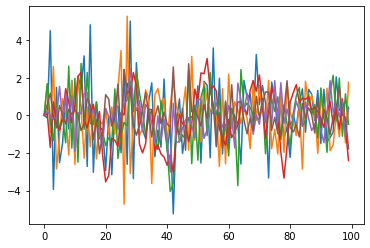

In [126]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 6, 12

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.4, high = 0.7, tril = False)

## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

### Perform OLS

In [127]:
def OLS(X):
    """Performs OLS on the data X"""
    
    # initialize OLS matrix
    W_OLS = np.zeros((n, n))
    
    # get per column
    for i in range(n):
        # closed form solution per OLS
        W_OLS[:, i] = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:, i]
        
    # return OLS solution
    return W_OLS

print(f"Dense OLS solution:\n{np.round(OLS(X), 2)}.")

Dense OLS solution:
[[-0.47 -0.02 -0.02 -0.01  0.01 -0.01]
 [ 0.46 -0.53  0.1  -0.03 -0.02  0.11]
 [ 0.78 -0.11 -0.29 -0.11  0.03  0.01]
 [ 0.42  0.11  0.44  0.81  0.16 -0.12]
 [-0.02 -0.77  0.89 -0.01 -0.03  0.01]
 [ 0.06  0.87 -0.17  0.65  0.05 -0.15]].


### Backwards selection step
Given a matrix $W$, we find the violating edge $W_{i, j}$ that minimally decreases the Mean Squared Error. We continue until we have no violators. In this manner, we do not unnecessarily remove any edges.

In [128]:
def get_possible_violators(W):
    nonzero = np.nonzero(W - np.diag(np.diag(W)))
    
    return list(zip(nonzero[0], nonzero[1]))

In [129]:
print(get_possible_violators(OLS(X)))

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)]


#### Get all edges violating acyclicity in the directed graph $G(W)$

In [130]:
def get_all_violating_edges(W):
    """Returns all the edges of W that violate DAG-ness"""
    
    # initialize set of violators
    violators = set()
    
    # convert W to a graph to utilize networkx to find all simple cycles
    G = networkx.from_numpy_matrix(W, create_using=networkx.DiGraph)
    
    possible_violators = get_possible_violators(W)
    
    # for each cycle
    for cycle in networkx.simple_cycles(G):
        # we get all cycles of length > 1 and write them in edge form
        edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle)) if len(cycle) > 1]
        
        # we add them all to the set, so that we do not have duplicates
        for edge in edges:
            violators.add(edge)
        
        # speed up, check if all violators are found
        if violators.issuperset(possible_violators): 
            return violators
            
    # we return all the violators
    return violators

print(f"All edges violating dag-ness in W_OLS: {get_all_violating_edges(OLS(X))}.")

All edges violating dag-ness in W_OLS: {(1, 3), (3, 0), (0, 2), (2, 1), (5, 1), (2, 5), (0, 3), (4, 0), (1, 2), (1, 5), (5, 0), (0, 4), (3, 4), (4, 1), (5, 4), (3, 2), (4, 5), (1, 4), (0, 5), (2, 3), (4, 2), (1, 0), (5, 3), (3, 5), (0, 1), (3, 1), (2, 0), (4, 3), (5, 2), (2, 4)}.


#### One Backwards Selection Step
We remove the directed edge $(i, j)$ that violates the DAGness, and is deemed "least important", i.e., removing this edge yields the smallest increase in MSE.

In [131]:
def backwards_selection_step(W, X):
    """Performs one backwards step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # get all violating edges
    violators = get_all_violating_edges(W)
    
    # if there are no violators, we are already done
    if len(violators) == 0: return W
    
    # variables to keep track of best
    best_col_to_change = None
    new_column = None
    score = np.inf

    # iterate over all violators
    for row, col in violators:
        # copy W_hat before modifying 
        W_copy = W.copy()
        
        # set index of violator to zero
        W_copy[row][col] = 0
    
        # get all non_zero indices after removing violator
        indices = W_copy[:, col].nonzero()[0]
        
        # perform least squares without this violator
        W_copy[indices, col] = np.linalg.inv(X[:-1, indices].T @ X[:-1, indices]) @ X[:-1, indices].T @ X[1:, col]
    
        # if we have improved, check if best choice so far
        if h.MSE(W_copy, X) < score:
            best_col_to_change = col
            new_column = W_copy[:, col]
            score = h.MSE(W_copy, X)
    
    # we greedily pick the best choice we have
    W[:, best_col_to_change] = new_column
    
    # return W_hat with one coefficient less
    return W

print(f"OLS solution after removing the least important violator:\n{np.round(backwards_selection_step(OLS(X), X), 2)}.")

OLS solution after removing the least important violator:
[[-0.47 -0.02 -0.02  0.    0.01 -0.01]
 [ 0.46 -0.53  0.1  -0.03 -0.02  0.11]
 [ 0.78 -0.11 -0.29 -0.11  0.03  0.01]
 [ 0.42  0.11  0.44  0.81  0.16 -0.12]
 [-0.02 -0.77  0.89 -0.01 -0.03  0.01]
 [ 0.06  0.87 -0.17  0.65  0.05 -0.15]].


#### Greedy Backwards OLS fully

In [132]:
def greedy_backwards_OLS(X):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W = backwards_selection_step(W, X)
    
    # return the DAG W
    return W

W_greedy_backwards_OLS = greedy_backwards_OLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS, 2)}.")

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.47  0.    0.    0.    0.    0.  ]
 [ 0.46 -0.49  0.11  0.    0.    0.  ]
 [ 0.78  0.   -0.29  0.    0.    0.  ]
 [ 0.42  0.    0.43  0.76  0.16  0.  ]
 [ 0.   -0.75  0.89  0.   -0.02  0.  ]
 [ 0.05  0.83 -0.18  0.63  0.   -0.13]].


#### Print Result and Mean Squared Error

In [133]:
if n <= 10: print(np.round(W_greedy_backwards_OLS, 2))
h.score(X, W_greedy_backwards_OLS, A_true);

[[-0.47  0.    0.    0.    0.    0.  ]
 [ 0.46 -0.49  0.11  0.    0.    0.  ]
 [ 0.78  0.   -0.29  0.    0.    0.  ]
 [ 0.42  0.    0.43  0.76  0.16  0.  ]
 [ 0.   -0.75  0.89  0.   -0.02  0.  ]
 [ 0.05  0.83 -0.18  0.63  0.   -0.13]]
True Positive Rate: 1.0.
True Negative Rate: 0.75.
False Prediction Rate: 0.333
Accuracy: 0.833.
R-Squared: 0.569
Mean Squared Error: 5.288


#### Compare Results to exhaustive search
Note: Exhaustive Search overfits heavily on the noise, so it might not be the best way to compare. Most important is to check we have everything.

In [134]:
W_exh = m._Exh(X)
if n <= 8: print(np.round(W_exh, 3))
h.score(X, W_exh, A_true);

100%|███████████████████████████████████████████████████████████████████████████████| 720/720 [00:02<00:00, 269.16it/s]

[[-0.467  0.     0.     0.     0.     0.   ]
 [ 0.461 -0.489  0.111  0.     0.     0.   ]
 [ 0.778  0.    -0.292  0.     0.     0.   ]
 [ 0.422  0.062  0.43   0.762  0.172  0.   ]
 [-0.019 -0.772  0.887  0.    -0.031  0.   ]
 [ 0.055  0.859 -0.179  0.635  0.063 -0.132]]
True Positive Rate: 1.0.
True Negative Rate: 0.625.
False Prediction Rate: 0.429
Accuracy: 0.75.
R-Squared: 0.57
Mean Squared Error: 5.278


#### Compare Results to Orthogonal Matching Pursuit

In [135]:
if n <= 10: print(np.round(m._OMP(X), 3))
h.score(X, m._OMP(X), A_true);

[[-0.468  0.     0.     0.     0.     0.   ]
 [ 0.459 -0.489  0.11   0.     0.     0.   ]
 [ 0.776  0.    -0.295  0.     0.     0.   ]
 [ 0.422  0.061  0.43   0.761  0.171  0.   ]
 [-0.02  -0.773  0.886  0.    -0.032  0.   ]
 [ 0.057  0.859 -0.177  0.636  0.064 -0.131]]
True Positive Rate: 1.0.
True Negative Rate: 0.625.
False Prediction Rate: 0.429
Accuracy: 0.75.
R-Squared: 0.57
Mean Squared Error: 5.278


In [136]:
def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2 * W2)  # (Zheng et al. 2018)
    h = np.trace(E) - n

    return h
    
def get_all_violating_edges_v2(W, epsilon = 1e-8):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(n):
        for j in range(n):
            # remove Wij
            tmp = W[i][j]
            W[i][j] = 0
            
            # check h
            h_diff = h_val - _h(W)
            
            # check change
            if h_diff > epsilon:
                violators.add((i, j))
            
            # add Wij back
            W[i][j] = tmp

    return violators

In [137]:
print(A_true)
rows, columns = np.nonzero(A_true)
print(list(zip(np.nonzero(A_true)[0], np.nonzero(A_true)[1])))

[[-0.46766047  0.          0.          0.          0.          0.        ]
 [ 0.40509745 -0.4822675   0.          0.          0.          0.        ]
 [ 0.68295417  0.         -0.4294552   0.          0.          0.        ]
 [ 0.43509115  0.          0.50965619  0.64038304  0.          0.        ]
 [ 0.         -0.66263795  0.58639851  0.          0.          0.        ]
 [ 0.          0.68343335  0.          0.53619694  0.          0.        ]]
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 2), (3, 0), (3, 2), (3, 3), (4, 1), (4, 2), (5, 1), (5, 3)]


In [138]:
def backwards_selection_step_v2(W, X, use_violators = True):
    """Performs one backwards step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # get all violating edges
    violators = get_all_violating_edges_v2(W)
    
    if not use_violators:
        violators = list(zip(np.nonzero(W)[0], np.nonzero(W)[1]))
    
    # if there are no violators, we are already done
    if len(violators) == 0: return W
    
    # variables to keep track of best
    best_col_to_change = None
    best_row_to_change = None
    new_column = None
    score = np.inf

    # iterate over all violators
    for row, col in violators:
        # copy W_hat before modifying 
        W_copy = W.copy()
        
        # set index of violator to zero
        W_copy[row][col] = 0
    
        # get all non_zero indices after removing violator
        indices = W_copy[:, col].nonzero()[0]
        
        # perform least squares without this violator
        W_copy[indices, col] = np.linalg.inv(X[:-1, indices].T @ X[:-1, indices]) @ X[:-1, indices].T @ X[1:, col]
    
        # if we have improved, check if best choice so far
        if h.MSE(W_copy, X) < score:
            best_col_to_change = col
            best_row_to_change = row
            new_column = W_copy[:, col]
            score = h.MSE(W_copy, X)
    
    # we greedily pick the best choice we have
    W[:, best_col_to_change] = new_column
    
    # return W_hat with one coefficient less
    return W, [best_row_to_change, best_col_to_change], score

OLS_after_one_step, edge_to_remove, score = backwards_selection_step_v2(OLS(X), X)
print(f"OLS solution after removing the least important violator:\n{np.round(OLS_after_one_step, 2)}.")

OLS solution after removing the least important violator:
[[-0.47 -0.02 -0.02  0.    0.01 -0.01]
 [ 0.46 -0.53  0.1  -0.03 -0.02  0.11]
 [ 0.78 -0.11 -0.29 -0.11  0.03  0.01]
 [ 0.42  0.11  0.44  0.81  0.16 -0.12]
 [-0.02 -0.77  0.89 -0.01 -0.03  0.01]
 [ 0.06  0.87 -0.17  0.65  0.05 -0.15]].


In [146]:
def greedy_backwards_OLS_v2(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step_v2(W, X)
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step_v2(W, X, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

T = 50
X = h.generate_var_2(T, n, A_true, P_true)
W_greedy_backwards_OLS_v2, edge_order, scores = greedy_backwards_OLS_v2(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS_v2, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.46  0.    0.    0.    0.    0.  ]
 [ 0.   -0.42  0.    0.    0.    0.  ]
 [ 0.54  0.   -0.55  0.    0.    0.  ]
 [ 0.47  0.    0.54  0.67  0.    0.  ]
 [ 0.   -0.48  0.66  0.    0.17  0.  ]
 [ 0.    0.59  0.    0.55  0.   -0.13]].
Importance of the removed edges, from least to most important:
[[2, 5], [5, 4], [2, 3], [1, 4], [5, 0], [3, 4], [0, 2], [0, 1], [3, 1], [4, 5], [1, 0], [1, 3], [4, 3], [5, 2], [2, 4], [0, 3], [0, 5], [1, 2], [4, 0], [0, 4], [2, 1], [1, 5], [3, 5], [4, 4], [5, 5], [4, 1], [1, 1], [5, 1], [4, 2], [5, 3], [0, 0], [3, 0], [2, 2], [3, 2], [2, 0], [3, 3]].


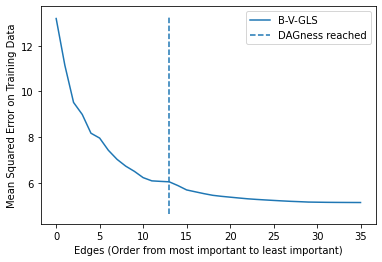

In [148]:
plt.xlabel("Edges (Order from most important to least important)")
plt.ylabel("Mean Squared Error on Training Data")
plt.vlines(len(np.nonzero(W_greedy_backwards_OLS_v2)[0]), min(scores) - 0.5, max(scores) + 0.1, linestyle = '--', label = "DAGness reached")
plt.plot(np.flip(np.array(scores)), label = "B-V-GLS")
plt.legend()

In [141]:
W_greedy_backwards_OLS = greedy_backwards_OLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS_v2, 2)}.")

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.47  0.    0.    0.    0.    0.  ]
 [ 0.46 -0.49  0.11  0.    0.    0.  ]
 [ 0.78  0.   -0.29  0.    0.    0.  ]
 [ 0.42  0.    0.43  0.76  0.16  0.  ]
 [-0.02 -0.75  0.89  0.   -0.02  0.  ]
 [ 0.06  0.83 -0.18  0.63  0.   -0.13]].


In [142]:
h.score(X, W_greedy_backwards_OLS_v2, A_true);

True Positive Rate: 1.0.
True Negative Rate: 0.708.
False Prediction Rate: 0.368
Accuracy: 0.806.
R-Squared: 0.57
Mean Squared Error: 5.288


[[ True False False False False False]
 [False  True False False False False]
 [ True False  True False False False]
 [ True False  True  True False False]
 [False  True  True False  True False]
 [False  True False  True False  True]]


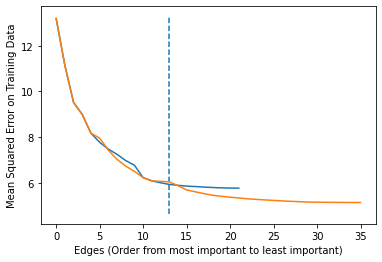

In [149]:
W_OMP, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

plt.xlabel("Edges (Order from most important to least important)")
plt.ylabel("Mean Squared Error on Training Data")
plt.plot(np.array(mses), label = "OMP")
plt.plot(np.flip(np.array(scores)))
plt.vlines(len(np.nonzero(W_greedy_backwards_OLS_v2)[0]), min(scores) - 0.5, max(scores) + 0.1, linestyle = '--', label = "DAGness reached")

W_OMP_bin = W_OMP.copy()
W_OMP_bin[W_OMP_bin != 0] = 1

W_greedy_backwards_OLS_v2_bin = W_greedy_backwards_OLS_v2.copy()
W_greedy_backwards_OLS_v2_bin[W_greedy_backwards_OLS_v2_bin != 0] = 1

print(np.logical_and(W_OMP_bin, W_greedy_backwards_OLS_v2))

### Model Mismatch

A:
[[ 0.    0.    0.    0.   -0.64]
 [ 0.    0.    0.    0.    0.  ]
 [-0.6  -0.46  0.    0.    0.  ]
 [ 0.    0.61  0.    0.    0.  ]
 [-0.64 -0.5   0.    0.    0.  ]]

P:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]].


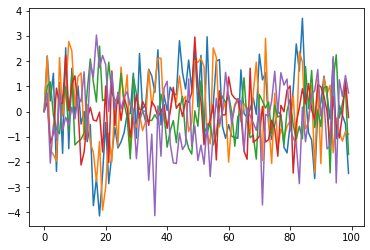

In [164]:
np.random.seed(seed = 123)

## Number of dimensions, number of edges, number of samples
T, n, s = 100, 5, 5

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.25, high = 0.75, tril = False)
A_true[0][4] = A_true[4][0]

## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

In [165]:
W_greedy_backwards_OLS_v2, edge_order, scores = greedy_backwards_OLS_v2(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS, 2)}.")
h.score(X, W_greedy_backwards_OLS_v2, A_true);
print()

print("Orthogonal Matching Pursuit:")
if n <= 10: print(np.round(m._OMP(X), 3))
h.score(X, m._OMP(X), A_true);
print()

print("Exhaustive:")
W_exh = m._Exh(X)
if n <= 8: print(np.round(W_exh, 3))
h.score(X, W_exh, A_true);

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

OLS solution after iteratively removing the least important violators until we have a DAG:
[[ 0.2   0.    0.    0.   -0.62]
 [ 0.    0.01  0.    0.    0.  ]
 [-0.69 -0.46  0.14  0.    0.  ]
 [ 0.    0.66  0.    0.06  0.  ]
 [ 0.   -0.46  0.    0.    0.02]].
True Positive Rate: 0.833.
True Negative Rate: 0.737.
False Prediction Rate: 0.5
Accuracy: 0.76.
R-Squared: 0.313
Mean Squared Error: 5.616

Orthogonal Matching Pursuit:
[[ 0.213  0.049  0.     0.    -0.616]
 [ 0.    -0.01   0.     0.     0.   ]
 [-0.682 -0.452  0.143 -0.116 -0.047]
 [-0.09   0.649  0.     0.073 -0.095]
 [ 0.    -0.456  0.     0.     0.03 ]]
True Positive Rate: 0.833.
True Negative Rate: 0.474.
False Prediction Rate: 0.667
Accuracy: 0.56.
R-Squared: 0.318
Mean Squared Error: 5.58

Exhaustive:


100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 216.22it/s]

[[ 0.212  0.049  0.     0.    -0.617]
 [ 0.    -0.01   0.     0.     0.   ]
 [-0.682 -0.453  0.143 -0.116 -0.047]
 [-0.09   0.65   0.     0.073 -0.094]
 [ 0.    -0.454  0.     0.     0.032]]
True Positive Rate: 0.833.
True Negative Rate: 0.474.
False Prediction Rate: 0.667
Accuracy: 0.56.
R-Squared: 0.318
Mean Squared Error: 5.58


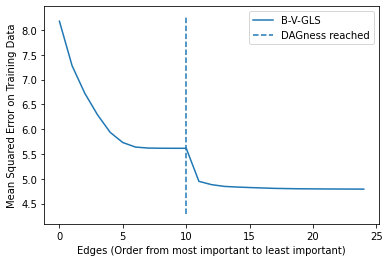

In [166]:
plt.xlabel("Edges (Order from most important to least important)")
plt.ylabel("Mean Squared Error on Training Data")
plt.vlines(len(np.nonzero(W_greedy_backwards_OLS_v2)[0]), min(scores) - 0.5, max(scores) + 0.1, linestyle = '--', label = "DAGness reached")
plt.plot(np.flip(np.array(scores)), label = "B-V-GLS")
plt.legend()

In [169]:
def greedy_backwards_OLS_v3(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step_v2(W, X, use_violators = False)
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step_v2(W, X, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

T = 50
X = h.generate_var_2(T, n, A_true, P_true)
W_greedy_backwards_OLS_v3, edge_order, scores = greedy_backwards_OLS_v3(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS_v3, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

OLS solution after iteratively removing the least important violators until we have a DAG:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [-0.54  0.    0.    0.    0.  ]].
Importance of the removed edges, from least to most important:
[[0, 1], [1, 4], [1, 1], [2, 2], [1, 2], [4, 2], [1, 0], [2, 3], [4, 4], [3, 4], [3, 2], [3, 3], [2, 4], [0, 2], [0, 3], [1, 3], [0, 0], [3, 0], [4, 3], [3, 1], [2, 1], [2, 0], [4, 1], [0, 4], [4, 0]].


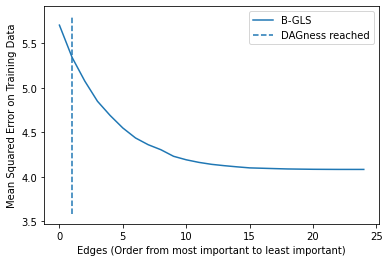

In [172]:
plt.xlabel("Edges (Order from most important to least important)")
plt.ylabel("Mean Squared Error on Training Data")
plt.vlines(len(np.nonzero(W_greedy_backwards_OLS_v3)[0]), min(scores) - 0.5, max(scores) + 0.1, linestyle = '--', label = "DAGness reached")
plt.plot(np.flip(np.array(scores)), label = "B-GLS")
plt.legend()